# Brain Tumor Detection

## Importing Libraries

In [9]:
# Libraries Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Data Pre-Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# Libraries for Model Creation
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import save_model

# General Purpose Libraries
from tqdm import tqdm
import os
import random

print('Libraries imported successfully!')

Libraries imported successfully!


## Paths of Dataset

In [10]:
# Paths
train_dir = r'/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

ERROR! Session/line number was not unique in database. History logging moved to new session 2


## Storing Training Data Info

In [11]:
# Training Set
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + '//' + label):
        train_paths.append(train_dir + '//' + label + '//' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
print('Training set setup complete!')

Training set setup complete!


## Storing Validation & Testing Data Info

In [12]:
# Testing & Validation Set Split
validation_ratio = 0.5

test_paths = []
test_labels = []
validation_paths = []
validation_labels = []

for label in os.listdir(test_dir):
    label_dir = test_dir + '//' + label
    images = os.listdir(label_dir)
    random.shuffle(images)

    num_validation = int(len(images) * validation_ratio)

    validation_images = images[:num_validation]
    testing_images = images[num_validation:]

    validation_paths.extend([label_dir + '//' + img for img in validation_images])
    validation_labels.extend([label] * len(validation_images))
    test_paths.extend([label_dir + '//' + img for img in testing_images])
    test_labels.extend([label] * len(testing_images))

validation_data = list(zip(validation_paths, validation_labels))
random.shuffle(validation_data)
validation_paths, validation_labels = zip(*validation_data)

test_data = list(zip(test_paths, test_labels))
random.shuffle(test_data)
test_paths, test_labels = zip(*test_data)

print('Testing & validation sets\' setup complete!')

Testing & validation sets' setup complete!


## Dataset Split Analysis

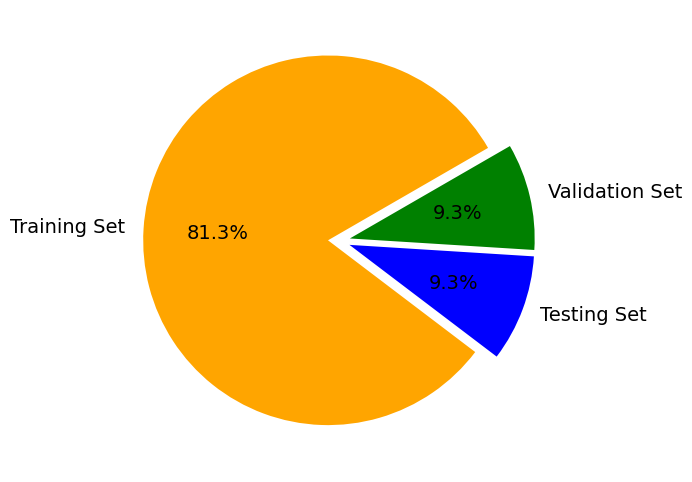

In [13]:
# Train-Validation-Test Split Analysis
plt.figure(figsize = (14, 6))
colours = ['Orange', 'Blue', 'Green']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels), len(validation_labels)],
        labels = ['Training Set', 'Testing Set', 'Validation Set'],
        colors = colours, autopct = '%.1f%%', explode = (0.06, 0.06, 0.06),
        startangle = 30);

## Classes/Labels Analysis

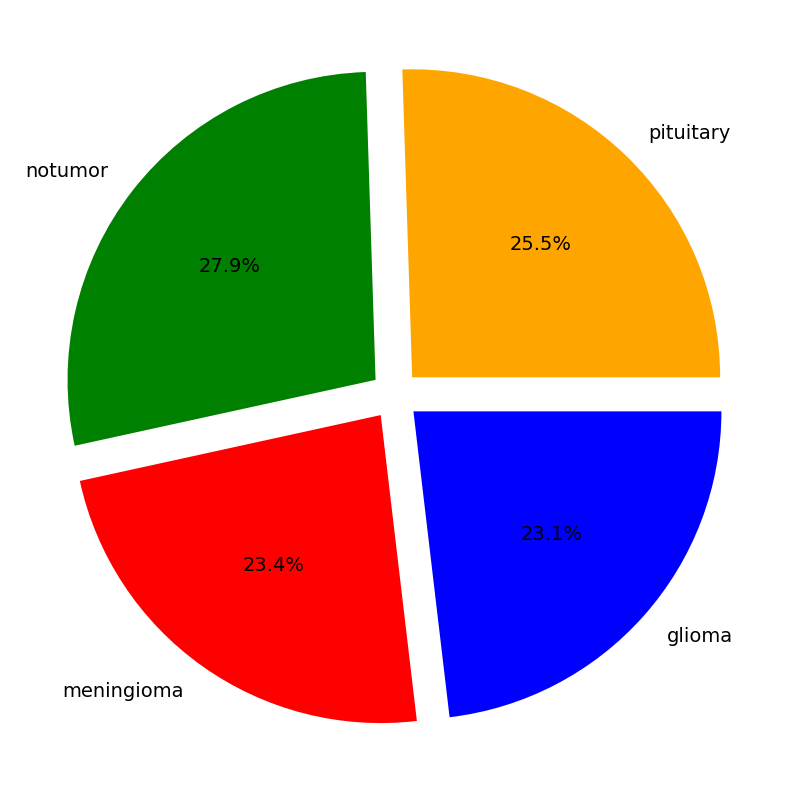

In [14]:
# Label Analysis of Dataset
plt.figure(figsize = (10, 10))
colours = ['Orange', 'Green', 'Red', 'Blue']
plt.pie([len(os.listdir(train_dir + '//' + label)) 
        for label in os.listdir(train_dir)],
        labels = os.listdir(train_dir),
        colors = colours,
        explode = (0.08, 0.08, 0.08, 0.08),
        autopct = '%1.1f%%')
plt.show()

## Image Enhancement

In [15]:
# Image Augmentation & Enhancement
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.9, 1.3))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.9, 1.3))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.9, 1.3))
    image = np.array(image) / 255.0
    return image

print('Image enhancement setup complete!')

Image enhancement setup complete!


## Sample Data

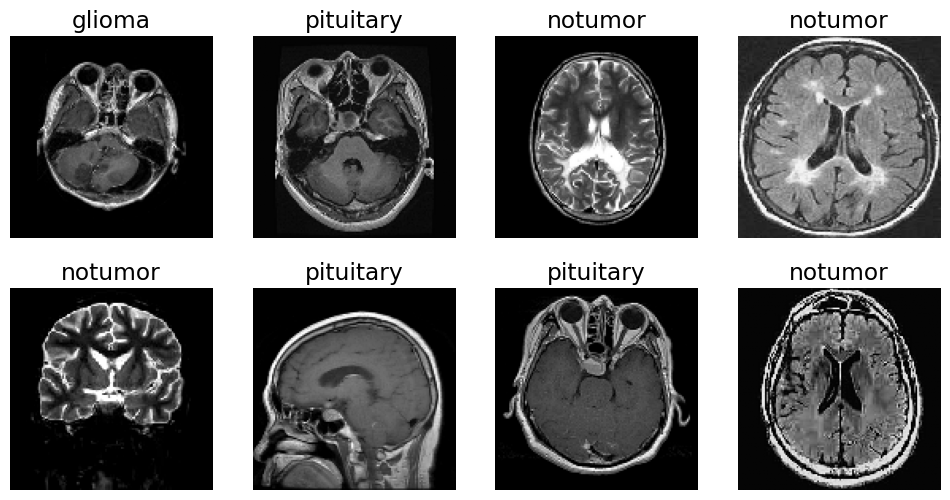

In [16]:
# Data Samples
IMAGE_SIZE = 128

def open_images(paths):
    images = []
    
    for path in paths:
        image = load_img(path, target_size = (IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
        
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize = (12, 6))

for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
    
plt.rcParams.update({'font.size': 12})
plt.show()

## Image Generation

In [17]:
# Data Generator
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    
    for x in labels:
        encoded.append(unique_labels.index(x))
        
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    
    for x in labels:
        decoded.append(unique_labels[x])
        
    return np.array(decoded)

def datagen(paths, labels, batch_size = 12, epochs = 1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x: x + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x: x + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels
            
print('Data generator setup complete!')

Data generator setup complete!


## CNN Model Creation

In [18]:
# Model Creation
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(4, activation = 'softmax'))
    model.compile(optimizer = 'adam', 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

## Neural Network Diagram

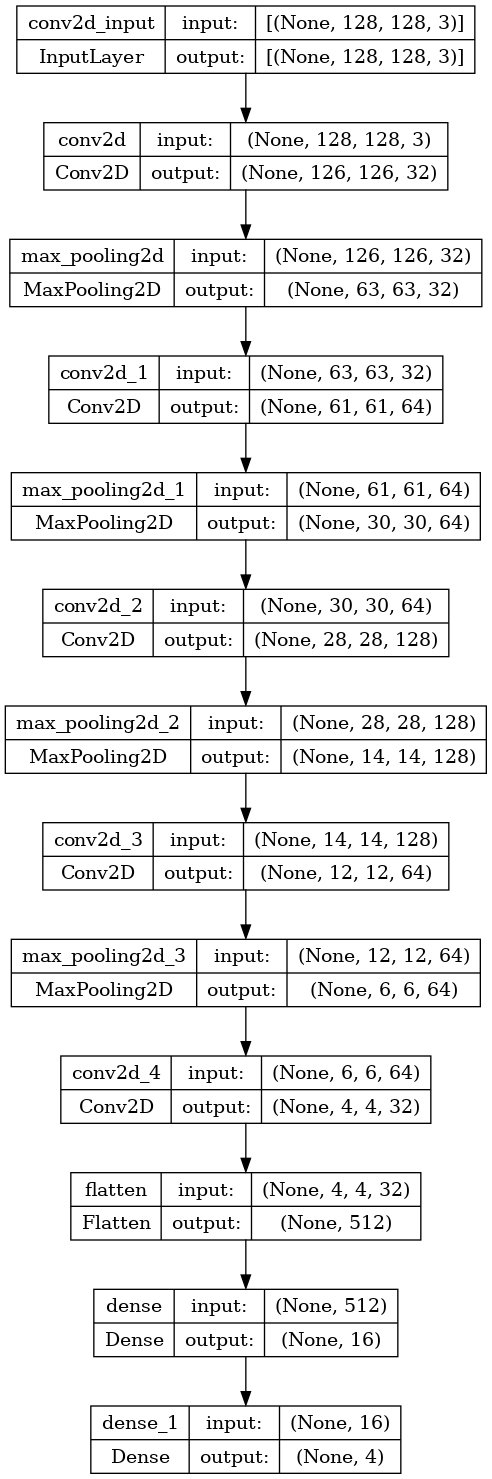

In [19]:
# Model Picturization
keras.utils.plot_model(model, show_shapes = True)

## Model Training

In [20]:
model_info = model.fit(
    datagen(
        train_paths, 
        train_labels, 
        batch_size = 32, 
        epochs = 20
    ), 
    steps_per_epoch = len(train_paths) // 32, 
    validation_data = datagen(
        validation_paths, 
        validation_labels, 
        batch_size = 12, 
        epochs = 20
    ),
    validation_steps = len(validation_paths) // 12,
    epochs = 20
)

print('Training complete!')

Epoch 1/20
178/178 [==============================] - 126s 697ms/step - loss: 0.8166 - accuracy: 0.6357 - val_loss: 0.6755 - val_accuracy: 0.7160
Epoch 2/20
178/178 [==============================] - 113s 639ms/step - loss: 0.5425 - accuracy: 0.7724 - val_loss: 0.5205 - val_accuracy: 0.7963
Epoch 3/20
178/178 [==============================] - 110s 618ms/step - loss: 0.4281 - accuracy: 0.8287 - val_loss: 0.4924 - val_accuracy: 0.8148
Epoch 4/20
178/178 [==============================] - 108s 607ms/step - loss: 0.3300 - accuracy: 0.8722 - val_loss: 0.3850 - val_accuracy: 0.8534
Epoch 5/20
178/178 [==============================] - 106s 598ms/step - loss: 0.2514 - accuracy: 0.9086 - val_loss: 0.3971 - val_accuracy: 0.8580
Epoch 6/20
178/178 [==============================] - 106s 597ms/step - loss: 0.2143 - accuracy: 0.9164 - val_loss: 0.2938 - val_accuracy: 0.8889
Epoch 7/20
178/178 [==============================] - 110s 621ms/step - loss: 0.1912 - accuracy: 0.9266 - val_loss: 0.3616 -

## Train Validation Curve

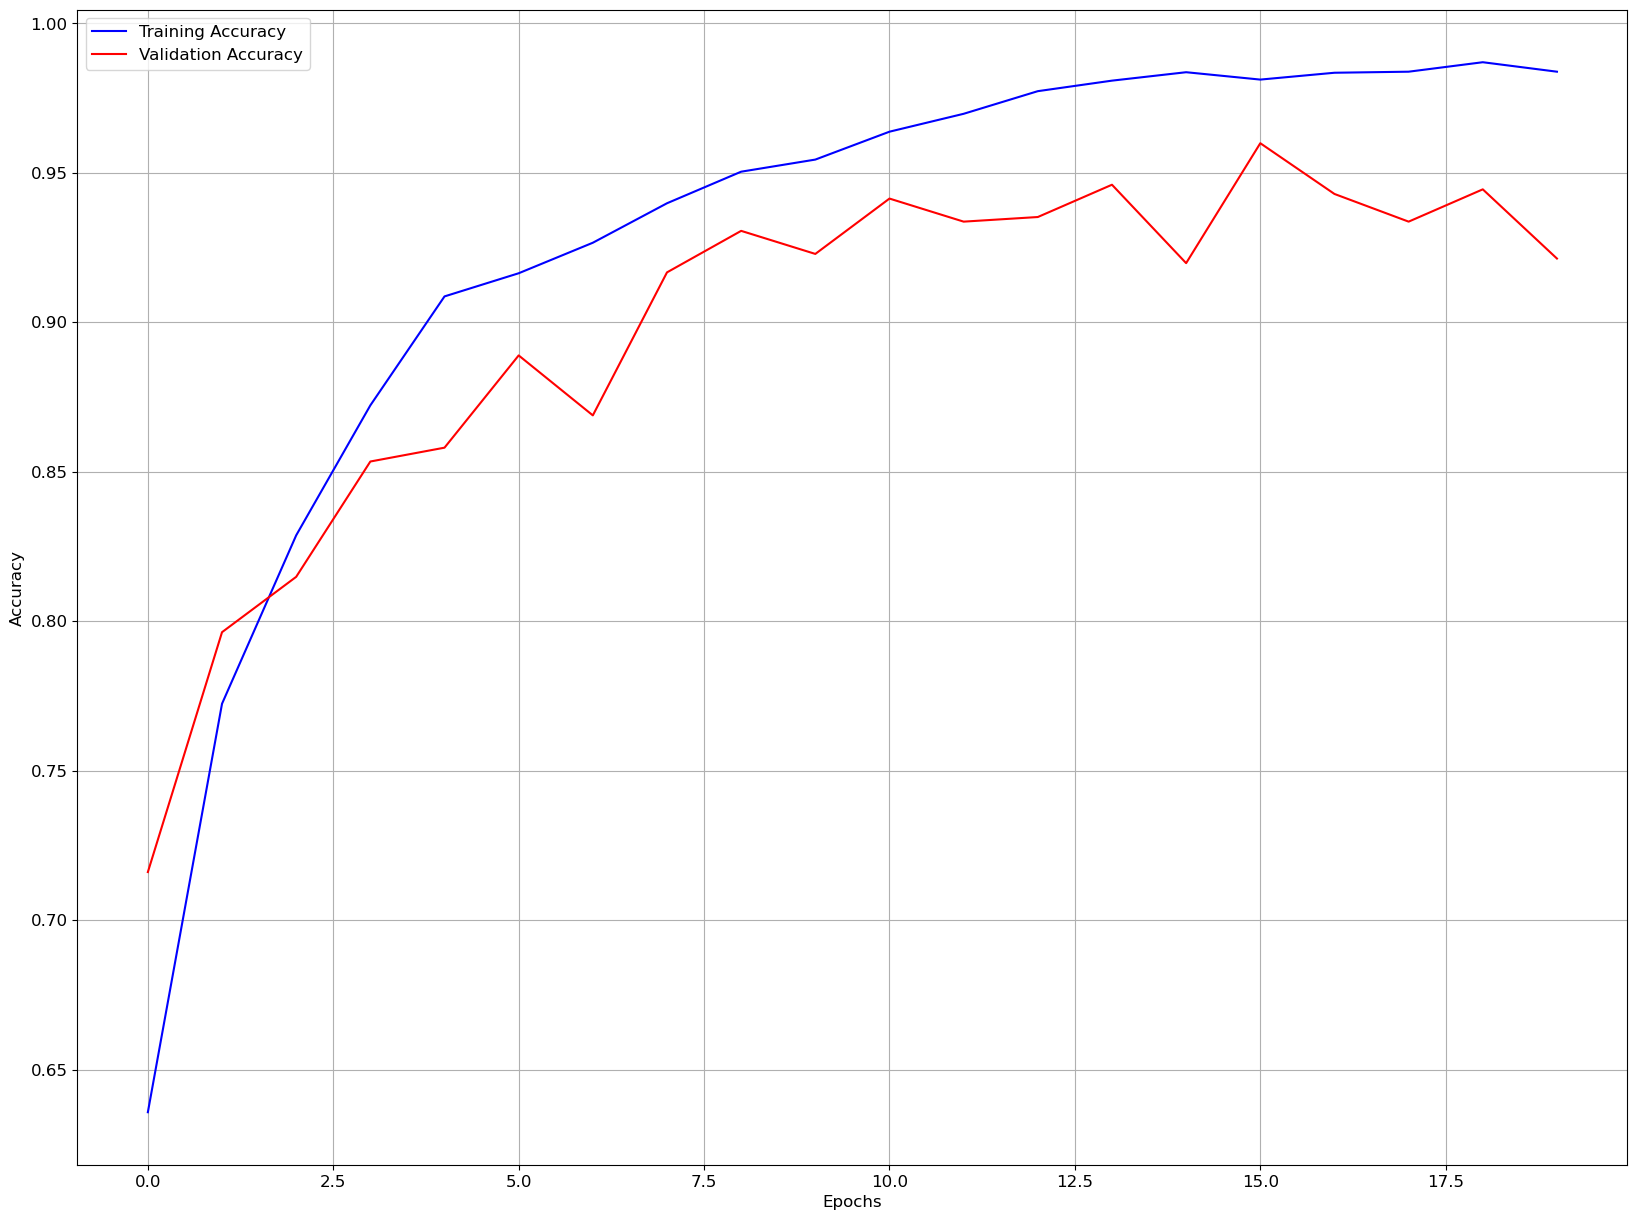

In [21]:
# Train-Validation Accuracy Curve
plt.figure(figsize = (20, 15))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(model_info.history['accuracy'], color = 'b', label = "Training Accuracy")
plt.plot(model_info.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

## Model Evaluation

In [22]:
# Model Evaluation
train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))

print(f'''\nTraining Evaluation:-
\t> Train Accuracy: {train_acc}
\t> Train Loss: {train_loss}
\nTesting Evaluation:-
\t> Testing Accuracy: {test_acc}
\t> Testing Loss: {test_loss}''')

21/21 [==============================] - 3s 148ms/step - loss: 0.3253 - accuracy: 0.9207

Training Evaluation:-
	> Train Accuracy: 0.9725140333175659
	> Train Loss: 0.08736078441143036

Testing Evaluation:-
	> Testing Accuracy: 0.9207317233085632
	> Testing Loss: 0.3252677321434021


## Prediction

In [23]:
# Prediction Report
prediction = model.predict(open_images(test_paths))
prediction = np.argmax(prediction, axis = 1)
print(classification_report(encode_label(test_labels), prediction, target_names = unique_labels))

21/21 [==============================] - 3s 150ms/step
              precision    recall  f1-score   support

   pituitary       0.89      0.99      0.94       150
     notumor       1.00      0.97      0.98       203
  meningioma       0.90      0.83      0.86       153
      glioma       0.91      0.91      0.91       150

    accuracy                           0.93       656
   macro avg       0.92      0.93      0.92       656
weighted avg       0.93      0.93      0.93       656



## Saving Model

In [24]:
save_model(model, '/kaggle/working/model.h5')